* Keras-based model (not PyTorch) - The bigest model


Found 7936 validated image filenames belonging to 6 classes.
Found 1984 validated image filenames belonging to 6 classes.
Found 2480 validated image filenames belonging to 6 classes.


C:\Users\Jaber\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1/10
Batch 1/992 ━━━━━━━━━━━━━━━━━━━━ 15:35:42
Accuracy: 0.0000 - Loss: 1.6865

Batch 2/992 ━━━━━━━━━━━━━━━━━━━━ 15:35:53
Accuracy: 0.1250 - Loss: 2.8387

Batch 3/992 ━━━━━━━━━━━━━━━━━━━━ 15:36:03
Accuracy: 0.2083 - Loss: 4.0671

Batch 4/992 ━━━━━━━━━━━━━━━━━━━━ 15:36:14
Accuracy: 0.2812 - Loss: 3.5803

Batch 5/992 ━━━━━━━━━━━━━━━━━━━━ 15:36:25
Accuracy: 0.2750 - Loss: 3.4327

Batch 6/992 ━━━━━━━━━━━━━━━━━━━━ 15:36:36
Accuracy: 0.2708 - Loss: 3.3700

Batch 7/992 ━━━━━━━━━━━━━━━━━━━━ 15:36:46
Accuracy: 0.2857 - Loss: 3.2943

Batch 8/992 ━━━━━━━━━━━━━━━━━━━━ 15:36:56
Accuracy: 0.3125 - Loss: 3.0776

Batch 9/992 ━━━━━━━━━━━━━━━━━━━━ 15:37:07
Accuracy: 0.3333 - Loss: 2.8945

Batch 10/992 ━━━━━━━━━━━━━━━━━━━━ 15:37:17
Accuracy: 0.3125 - Loss: 2.9569

Batch 11/992 ━━━━━━━━━━━━━━━━━━━━ 15:37:28
Accuracy: 0.3068 - Loss: 2.8177

Batch 12/992 ━━━━━━━━━━━━━━━━━━━━ 15:37:38
Accuracy: 0.2917 - Loss: 2.7474

Batch 13/992 ━━━━━━━━━━━━━━━━━━━━ 15:37:49
Accuracy: 0.2981 - Loss: 2.7376

Batch 14/

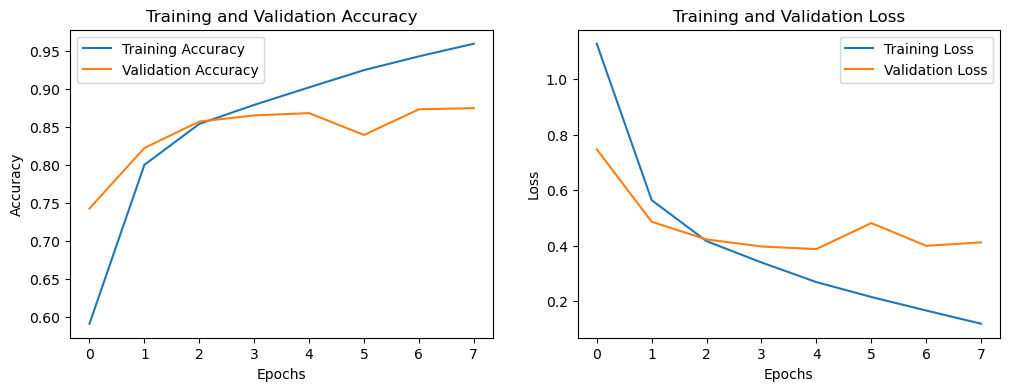

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, GlobalAveragePooling2D, LayerNormalization,
    Dropout, Conv2D, Add, Multiply, Layer, Concatenate,
    MultiHeadAttention, DepthwiseConv2D
)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datetime import datetime
from tensorflow.keras import backend as K  # Import Keras backend for shape handling

# Parameters
num_classes = 6
image_size = (224, 224)
dropout_rate = 0.1
batch_size = 8  # Adjusted batch size to have 793 steps per epoch
epochs = 10
learning_rate = 1e-4
window_size = 7  # Swin Transformer window size

# Attention-Guided Feature Fusion (AGFF) Layer with Feature Calibration
class AttentionGuidedFeatureFusion(Layer):
    def __init__(self, conv_channels=768, swin_channels=768, **kwargs):
        super(AttentionGuidedFeatureFusion, self).__init__(**kwargs)
        self.conv_channels = conv_channels
        self.swin_channels = swin_channels

    def build(self, input_shape):
        # Adjust num_channels to account for projection
        num_channels = (self.conv_channels // 2) + (self.swin_channels // 2)  # 384 + 384 = 768
        self.conv_spatial = Conv2D(1, kernel_size=1, activation='sigmoid', name='conv_spatial')
        self.dense1 = Dense(num_channels // 8, activation='relu', name='dense1')  # 768 // 8 = 96
        self.dense2 = Dense(num_channels, activation='sigmoid', name='dense2')      # 768

        # Feature calibration layers
        self.norm1 = LayerNormalization(epsilon=1e-6, name='norm1')
        self.norm2 = LayerNormalization(epsilon=1e-6, name='norm2')
        self.proj_conv = Dense(self.conv_channels // 2, activation='relu', name='proj_conv')  # 384
        self.proj_swin = Dense(self.swin_channels // 2, activation='relu', name='proj_swin')  # 384
        self.weight_conv = self.add_weight(name='weight_conv', shape=(1,), initializer='ones', trainable=True)
        self.weight_swin = self.add_weight(name='weight_swin', shape=(1,), initializer='ones', trainable=True)

        super(AttentionGuidedFeatureFusion, self).build(input_shape)

    def call(self, inputs):
        conv_features, swin_features = inputs

        # Feature Calibration
        conv_features = self.norm1(conv_features)
        swin_features = self.norm2(swin_features)

        conv_features = self.proj_conv(conv_features)  # [B,7,7,384]
        swin_features = self.proj_swin(swin_features)  # [B,7,7,384]

        # Re-weighting
        conv_features = conv_features * self.weight_conv
        swin_features = swin_features * self.weight_swin

        # Concatenate calibrated features
        combined_features = Concatenate(name='concatenate')([conv_features, swin_features])  # [B,7,7,768]

        # Spatial Attention Mechanism
        spatial_attention = self.conv_spatial(combined_features)  # [B,7,7,1]
        spatial_attention = Multiply(name='spatial_attention')([spatial_attention, combined_features])  # [B,7,7,768]

        # Channel Attention Mechanism
        channel_attention = GlobalAveragePooling2D(name='global_avg_pool')(combined_features)  # [B,768]
        channel_attention = self.dense1(channel_attention)  # [B,96]
        channel_attention = self.dense2(channel_attention)  # [B,768]
        channel_attention = tf.expand_dims(tf.expand_dims(channel_attention, 1), 1)  # [B,1,1,768]
        channel_attention = Multiply(name='channel_attention')([combined_features, channel_attention])  # [B,7,7,768]

        # Combine spatial and channel attention outputs
        fused_output = Add(name='fused_output')([spatial_attention, channel_attention])  # [B,7,7,768]
        return fused_output

    def get_config(self):
        config = super(AttentionGuidedFeatureFusion, self).get_config()
        config.update({
            "conv_channels": self.conv_channels,
            "swin_channels": self.swin_channels
        })
        return config

# Complete Swin Transformer Implementation
class SwinTransformerBlock(Layer):
    def __init__(self, dim, num_heads, window_size=7, mlp_ratio=4., dropout=0., **kwargs):
        super(SwinTransformerBlock, self).__init__(**kwargs)
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.mlp_ratio = mlp_ratio

        self.norm1 = LayerNormalization(epsilon=1e-6, name='norm1')
        self.attn = MultiHeadAttention(num_heads=num_heads, key_dim=dim // num_heads, name='multi_head_attn')
        self.dropout1 = Dropout(dropout, name='dropout1')
        self.norm2 = LayerNormalization(epsilon=1e-6, name='norm2')
        self.mlp = tf.keras.Sequential([
            Dense(int(dim * mlp_ratio), activation='gelu', name='mlp_dense1'),
            Dense(dim, name='mlp_dense2'),
        ], name='mlp')
        self.dropout2 = Dropout(dropout, name='dropout2')

    def call(self, x):
        # x: [B, H, W, C]
        shortcut = x
        x = self.norm1(x)
        x = self.attn(x, x)  # [B, H, W, C]
        x = self.dropout1(x)
        x = Add(name='attn_add')([shortcut, x])

        # MLP
        shortcut = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.dropout2(x)
        x = Add(name='mlp_add')([shortcut, x])

        return x

    def get_config(self):
        config = super(SwinTransformerBlock, self).get_config()
        config.update({
            "dim": self.dim,
            "num_heads": self.num_heads,
            "window_size": self.window_size,
            "mlp_ratio": self.mlp_ratio,
            "dropout": self.dropout1.rate
        })
        return config

class SwinTransformerStage(Layer):
    def __init__(self, dim, num_heads, window_size=7, num_blocks=2, mlp_ratio=4., dropout=0., downsample=True, **kwargs):
        super(SwinTransformerStage, self).__init__(**kwargs)
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.num_blocks = num_blocks
        self.downsample = downsample

        # Register each block as an attribute
        for i in range(num_blocks):
            block = SwinTransformerBlock(dim, num_heads, window_size, mlp_ratio, dropout, name=f'swin_block_{i}')
            self.__setattr__(f'swin_block_{i}', block)

        self.norm = LayerNormalization(epsilon=1e-6, name='stage_norm')
        if self.downsample:
            self.downsample_layer = Conv2D(dim * 2, kernel_size=2, strides=2, padding='same', name='stage_downsample')
        else:
            self.downsample_layer = None

    def call(self, x):
        # x: [B, H*W, C]
        B = tf.shape(x)[0]
        N = tf.shape(x)[1]
        C = tf.shape(x)[2]
        H = tf.cast(tf.math.sqrt(tf.cast(N, tf.float32)), tf.int32)
        W = H  # assuming square

        x = tf.reshape(x, [B, H, W, C])  # [B, H, W, C]

        for i in range(self.num_blocks):
            block = self.__getattribute__(f'swin_block_{i}')
            x = block(x)

        x = self.norm(x)
        if self.downsample:
            x = self.downsample_layer(x)
            H = H // 2
            W = W // 2
            C = self.dim * 2
            x = tf.reshape(x, [B, H * W, C])
        else:
            x = tf.reshape(x, [B, H * W, C])

        return x

    def get_config(self):
        config = super(SwinTransformerStage, self).get_config()
        config.update({
            "dim": self.dim,
            "num_heads": self.num_heads,
            "window_size": self.window_size,
            "num_blocks": self.num_blocks,
            "mlp_ratio": self.mlp_ratio,
            "dropout": self.dropout1.rate if hasattr(self, 'dropout1') else 0.,
            "downsample": self.downsample
        })
        return config

class SwinTransformer(Layer):
    def __init__(self, embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24],
                 window_size=7, mlp_ratio=4., dropout=0., **kwargs):
        super(SwinTransformer, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.depths = depths
        self.num_heads = num_heads
        self.window_size = window_size
        self.mlp_ratio = mlp_ratio
        self.dropout = dropout

        self.patch_embed = Conv2D(embed_dim, kernel_size=4, strides=4, padding='same', name='patch_embed')  # Patch Embedding

        # Register each stage as a separate attribute
        self.stages = []
        for i in range(len(depths)):
            # Prevent downsampling in the last stage
            downsample = True if i < len(depths) - 1 else False
            stage = SwinTransformerStage(
                dim=embed_dim * (2 ** i),
                num_heads=num_heads[i],
                window_size=window_size,
                num_blocks=depths[i],
                mlp_ratio=mlp_ratio,
                dropout=dropout,
                downsample=downsample,
                name=f'swin_stage_{i}'
            )
            self.stages.append(stage)
            self.__setattr__(f'swin_stage_{i}', stage)  # Register the stage

    def call(self, x):
        x = self.patch_embed(x)  # [B, H/4, W/4, embed_dim]
        B = tf.shape(x)[0]
        H = tf.shape(x)[1]
        W = tf.shape(x)[2]
        C = tf.shape(x)[3]
        x = tf.reshape(x, [B, H * W, C])  # [B, H*W, C]

        for stage in self.stages:
            x = stage(x)

        # Calculate final H and W based on downsampling
        final_stage = self.stages[-1]
        if final_stage.downsample:
            final_H = H // (2 ** (len(self.stages)))
            final_W = W // (2 ** (len(self.stages)))
            final_C = final_stage.dim * 2
        else:
            final_H = H // (2 ** (len(self.stages) - 1))
            final_W = W // (2 ** (len(self.stages) - 1))
            final_C = final_stage.dim

        x = tf.reshape(x, [B, final_H, final_W, final_C])  # [B, H_final, W_final, C_final]
        return x

    def get_config(self):
        config = super(SwinTransformer, self).get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "depths": self.depths,
            "num_heads": self.num_heads,
            "window_size": self.window_size,
            "mlp_ratio": self.mlp_ratio,
            "dropout": self.dropout
        })
        return config

# Complete ConvNeXt Implementation
class ConvNeXtBlock(Layer):
    def __init__(self, filters, drop_path=0., layer_scale_init_value=1e-6, **kwargs):
        super(ConvNeXtBlock, self).__init__(**kwargs)
        self.norm = LayerNormalization(epsilon=1e-6, name='convnext_block_norm')
        self.dwconv = DepthwiseConv2D(kernel_size=7, padding='same', name='convnext_block_dwconv')  # Depthwise Conv
        self.pwconv1 = Conv2D(filters * 4, kernel_size=1, activation='gelu', name='convnext_block_pwconv1')  # Pointwise Conv 1
        self.pwconv2 = Conv2D(filters, kernel_size=1, name='convnext_block_pwconv2')  # Pointwise Conv 2
        self.drop_path = Dropout(drop_path, name='convnext_block_drop_path') if drop_path > 0. else lambda x: x
        # Initialize gamma as a trainable scalar per channel
        self.gamma = self.add_weight(
            shape=(filters,),
            initializer=tf.keras.initializers.Constant(layer_scale_init_value),
            trainable=True,
            name='gamma'
        )

    def call(self, x):
        input = x
        x = self.norm(x)
        x = self.dwconv(x)
        x = self.pwconv1(x)
        x = self.pwconv2(x)
        # Reshape gamma for broadcasting
        gamma = tf.reshape(self.gamma, (1, 1, 1, -1))
        x = x * gamma
        x = self.drop_path(x)
        return Add(name='convnext_block_add')([input, x])

    def get_config(self):
        config = super(ConvNeXtBlock, self).get_config()
        config.update({
            "filters": self.gamma.shape[-1],
            "drop_path": self.drop_path.rate if isinstance(self.drop_path, Dropout) else 0.,
            "layer_scale_init_value": K.get_value(self.gamma)[0]  # Assumes uniform initialization
        })
        return config

class ConvNeXtStage(Layer):
    def __init__(self, filters, depth, drop_path_rates, layer_scale_init_value=1e-6, downsample=True, **kwargs):
        super(ConvNeXtStage, self).__init__(**kwargs)
        self.filters = filters
        self.depth = depth
        self.downsample = downsample

        # Register each block as an attribute
        for i, dp in enumerate(drop_path_rates):
            block = ConvNeXtBlock(filters, drop_path=dp, layer_scale_init_value=layer_scale_init_value, name=f'convnext_stage_{filters}_block_{i}')
            self.__setattr__(f'convnext_stage_{filters}_block_{i}', block)

        if self.downsample:
            self.downsample_layer = Conv2D(filters * 2, kernel_size=2, strides=2, padding='same', name=f'convnext_stage_{filters}_downsample')
        else:
            self.downsample_layer = None

    def call(self, x):
        for i in range(self.depth):
            block = self.__getattribute__(f'convnext_stage_{self.filters}_block_{i}')
            x = block(x)
        if self.downsample_layer:
            x = self.downsample_layer(x)
        return x

    def get_config(self):
        config = super(ConvNeXtStage, self).get_config()
        config.update({
            "filters": self.filters,
            "depth": self.depth,
            "drop_path_rates": [self.__getattribute__(f'convnext_stage_{self.filters}_block_{i}').drop_path.rate for i in range(self.depth)],
            "layer_scale_init_value": K.get_value(self.__getattribute__(f'convnext_stage_{self.filters}_block_0').gamma)[0],
            "downsample": self.downsample
        })
        return config

class ConvNeXt(Layer):
    def __init__(self, depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], drop_path_rate=0.2, layer_scale_init_value=1e-6, **kwargs):
        super(ConvNeXt, self).__init__(**kwargs)
        self.depths = depths
        self.dims = dims
        self.drop_path_rate = drop_path_rate
        self.layer_scale_init_value = layer_scale_init_value
        self.stem = Conv2D(dims[0], kernel_size=4, strides=4, padding='same', name='convnext_stem')  # Initial embedding

        # Calculate drop path rates
        total_blocks = sum(depths)
        dp_rates = np.linspace(0, drop_path_rate, total_blocks).tolist()
        dp_idx = 0

        # Register each stage as an attribute
        for i, (depth, dim) in enumerate(zip(depths, dims)):
            drop_path_rates = dp_rates[dp_idx:dp_idx + depth]
            downsample = True if i < len(depths) - 1 else False
            stage = ConvNeXtStage(
                filters=dim,
                depth=depth,
                drop_path_rates=drop_path_rates,
                layer_scale_init_value=layer_scale_init_value,
                downsample=downsample,
                name=f'convnext_stage_{dim}'
            )
            self.__setattr__(f'convnext_stage_{dim}', stage)
            dp_idx += depth

    def call(self, x):
        x = self.stem(x)  # Shape: [B, H/4, W/4, 96]
        for dim in self.dims:
            stage = self.__getattribute__(f'convnext_stage_{dim}')
            x = stage(x)
        return x  # Final feature map with 768 channels

    def get_config(self):
        config = super(ConvNeXt, self).get_config()
        config.update({
            "depths": self.depths,
            "dims": self.dims,
            "drop_path_rate": self.drop_path_rate,
            "layer_scale_init_value": self.layer_scale_init_value
        })
        return config

# Feature Alignment Layer (unchanged)
class FeatureAlignmentLayer(Layer):
    def __init__(self, **kwargs):
        super(FeatureAlignmentLayer, self).__init__(**kwargs)

    def call(self, inputs):
        conv_features, swin_features = inputs
        conv_shape = tf.shape(conv_features)[1:3]
        swin_features = tf.image.resize(swin_features, size=conv_shape)
        return swin_features

    def get_config(self):
        config = super(FeatureAlignmentLayer, self).get_config()
        return config

def create_convnext_swin_model(input_shape, num_classes):
    inputs = Input(shape=input_shape, name='input_layer')

    # ConvNeXt Backbone
    convnext = ConvNeXt(name='convnext_backbone')
    conv_features = convnext(inputs)  # Shape: (None, 7, 7, 768)

    # Swin Transformer Backbone
    swin_transformer = SwinTransformer(name='swin_transformer_backbone')
    swin_features = swin_transformer(inputs)  # Output shape: [B, 7, 7, 768]

    # Align swin_features to conv_features
    swin_features = FeatureAlignmentLayer(name='feature_alignment')([conv_features, swin_features])

    # Since both ConvNeXt and SwinTransformer output 768 channels, no adjustment needed
    # Apply Attention-Guided Feature Fusion (AGFF) with Feature Calibration
    fused_features = AttentionGuidedFeatureFusion(conv_channels=768, swin_channels=768, name='agff')([conv_features, swin_features])

    x = LayerNormalization(epsilon=1e-6, name='final_norm')(fused_features)
    x = GlobalAveragePooling2D(name='global_avg_pool')(x)
    x = Dropout(dropout_rate, name='dropout_final')(x)
    outputs = Dense(num_classes, activation="softmax", name='output_layer')(x)

    model = Model(inputs=inputs, outputs=outputs, name='ConvNeXt_SwinTransformer_Model')
    return model

# Compile Model
input_shape = (224, 224, 3)
model = create_convnext_swin_model(input_shape, num_classes)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Data Loading and Preprocessing
csv_path = r"C:\Users\Jaber\OneDrive - University of Florida\Educational\GitHub\Ultrasound_Fetal\Data\FETAL_PLANES_DB_data.csv"
df = pd.read_csv(csv_path, delimiter=";")

# Shuffle the DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Add .png extension to each image name
df["Image_name"] = df["Image_name"].apply(lambda x: f"{x}.png")

# Split into train+val and test sets
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Image data generator with train-validation split
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_dataframe(
    dataframe=train_val_df,
    directory=r"C:\Users\Jaber\OneDrive - University of Florida\Educational\GitHub\Ultrasound_Fetal\Data\Images",
    x_col="Image_name",
    y_col="Plane",
    target_size=image_size,
    class_mode="sparse",
    batch_size=batch_size,
    subset="training",
    shuffle=True
)

val_gen = datagen.flow_from_dataframe(
    dataframe=train_val_df,
    directory=r"C:\Users\Jaber\OneDrive - University of Florida\Educational\GitHub\Ultrasound_Fetal\Data\Images",
    x_col="Image_name",
    y_col="Plane",
    target_size=image_size,
    class_mode="sparse",
    batch_size=batch_size,
    subset="validation",
    shuffle=False
)

# Test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=r"C:\Users\Jaber\OneDrive - University of Florida\Educational\GitHub\Ultrasound_Fetal\Data\Images",
    x_col="Image_name",
    y_col="Plane",
    target_size=image_size,
    class_mode="sparse",
    batch_size=batch_size,
    shuffle=False
)

# Simplified Metrics Callback
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, total_batches):
        super().__init__()
        self.total_batches = total_batches

    def on_epoch_begin(self, epoch, logs=None):
        print(f"\nEpoch {epoch + 1}/{self.params['epochs']}")

    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        accuracy = logs.get('accuracy', 0)
        loss = logs.get('loss', 0)
        current_time = datetime.now().strftime("%H:%M:%S")
        print(f"Batch {batch+1}/{self.total_batches} ━━━━━━━━━━━━━━━━━━━━ {current_time}")
        print(f"Accuracy: {accuracy:.4f} - Loss: {loss:.4f}\n")

    def get_config(self):
        config = super(MetricsCallback, self).get_config()
        config.update({"total_batches": self.total_batches})
        return config

# Calculate total_batches for training
total_train_batches = train_gen.samples // train_gen.batch_size
if train_gen.samples % train_gen.batch_size != 0:
    total_train_batches += 1

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=[MetricsCallback(total_train_batches), early_stopping],
    verbose=0  # Set verbose to 0 to suppress default output
)

# Evaluate on Test Data
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Calculate Metrics on Test Set
test_steps = test_gen.samples // test_gen.batch_size + int(test_gen.samples % test_gen.batch_size != 0)
test_preds = model.predict(test_gen, steps=test_steps)
test_labels = test_gen.classes

# Convert predictions to label format
test_preds = np.argmax(test_preds, axis=1)

precision = precision_score(test_labels, test_preds, average='weighted')
recall = recall_score(test_labels, test_preds, average='weighted')
f1 = f1_score(test_labels, test_preds, average='weighted')
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

# Visualization of Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history.get('val_accuracy'), label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history.get('val_loss'), label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()
